In [1]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from PIL import Image
from tensorflow.keras.layers import BatchNormalization, Conv2D, ConvLSTM2D, Input

In [3]:
%matplotlib inline

In [4]:
global_seed = 42
np.random.seed(global_seed)

main_path = "/content/gdrive/My Drive/Remote LSTM"
sub_paths = ["LostCreek_site_MI", "NE3_Site_NE", "TonziRanch_site_CA", "WalnutGulchWatershed_AZ"]

select = 3
data_path = sub_paths[select]

box = os.listdir(f"{main_path}/MODIS Data/MODIS_LE_US_{data_path}")

In [5]:
trained_models = ["model_convlstm_LostCreek_site_MI",
                  "model_convlstm_NE3_Site_NE",
                  "model_convlstm_TonziRanch_CA_DailyData",
                  "model_convlstm_WalnutGulchWatershed_AZ_DailyData"]

saved_model = trained_models[select]

In [6]:
data = []
threshold = 32000

for n in box:
    im = Image.open(f"{main_path}/MODIS Data/MODIS_LE_US_{data_path}/{n}")
    map = np.array(im)
    map = np.reshape(map, (map.shape[0], map.shape[1], 1))

    i = map > threshold
    map[i] = 0

    data.append(map)

In [7]:
data = np.array(data)

scale = scale = np.percentile(data, 99.9)

data = data / scale

h, w, c = data.shape[1], data.shape[2], data.shape[3]

frame_data = np.reshape(data, (data.shape[0], 1, h, w, c))

In [8]:
data.shape

(804, 26, 67, 1)

In [9]:
def shift_frames(data, shifts):
    shifted_data = np.roll(data, 1, axis=0)
    shifted_data[0, :, :, :] = 0

    if shifts > 1:
        next = shift_frames(shifted_data, shifts - 1)
        shifted_data = np.concatenate((next, shifted_data), axis=1)

    return shifted_data

In [10]:
frames = 23

shifted_data = shift_frames(frame_data, frames)

In [11]:
for cutoff in range(len(box)):
    if box[cutoff][23:27]=="2019":
        break

In [12]:
if select in (0, 1, 2):
    start = 45
else:
    start = 23

In [13]:
y_train = data[start:cutoff]
y_test = data[cutoff:]

x_train = shifted_data[start:cutoff]
x_test = shifted_data[cutoff:]

In [14]:
print(y_train.shape)
print(y_test.shape)
print(x_train.shape)
print(x_test.shape)

(735, 26, 67, 1)
(46, 26, 67, 1)
(735, 23, 26, 67, 1)
(46, 23, 26, 67, 1)


In [15]:
def LE_map_model(input_dim):
    input = Input(shape=input_dim)

    cr1 = ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(input)
    bn1 = BatchNormalization()(cr1)

    cr2 = ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(bn1)
    bn2 = BatchNormalization()(cr2)

    cr3 = ConvLSTM2D(64, (3, 3), padding="same", return_sequences=False, dropout=0.1, recurrent_dropout=0.1)(bn2)
    bn3 = BatchNormalization()(cr3)

    output = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(bn3)

    model = tf.keras.Model(inputs=[input], outputs=[output])
    model.compile(loss="mean_squared_error", optimizer="adam")

    return model

In [16]:
def LE_map_model2(input_dim):
    input = Input(shape=input_dim)

    cr1 = ConvLSTM2D(50, (3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(input)
    bn1 = BatchNormalization()(cr1)

    cr2 = ConvLSTM2D(50, (3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(bn1)
    bn2 = BatchNormalization()(cr2)

    cr3 = ConvLSTM2D(50, (3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(bn2)
    bn3 = BatchNormalization()(cr3)

    cr4 = ConvLSTM2D(50, (3, 3), padding="same", return_sequences=False, dropout=0.1, recurrent_dropout=0.1)(bn3)
    bn4 = BatchNormalization()(cr4)

    output = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(bn4)

    model = tf.keras.Model(inputs=[input], outputs=[output])
    model.compile(loss="mean_squared_error", optimizer="adam")

    return model

In [17]:
load_saved = False
retrain = False

In [18]:
if load_saved:
    model = tf.keras.models.load_model(f"{main_path}/models/{saved_model}")
else:
    model = LE_map_model((frames, h, w, c))

In [19]:
model.summary(line_length=150)

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
input_1 (InputLayer)                                               [(None, 23, 26, 67, 1)]                                     0                      
______________________________________________________________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)                                          (None, 23, 26, 67, 64)                                      150016                 
______________________________________________________________________________________________________________________________________________________
batch_normalization (BatchNormalization)                           (None, 23, 2

In [20]:
if load_saved:
    if retrain:
        model.fit(x_train, y_train, epochs=200, batch_size=16, verbose=2)
    else:
        print("Skipping training")
else:
    model.fit(x_train, y_train, epochs=200, batch_size=16, verbose=2)

Epoch 1/200
46/46 - 43s - loss: 0.1060
Epoch 2/200
46/46 - 31s - loss: 0.0454
Epoch 3/200
46/46 - 31s - loss: 0.0279
Epoch 4/200
46/46 - 31s - loss: 0.0214
Epoch 5/200
46/46 - 32s - loss: 0.0186
Epoch 6/200
46/46 - 32s - loss: 0.0169
Epoch 7/200
46/46 - 31s - loss: 0.0157
Epoch 8/200
46/46 - 32s - loss: 0.0149
Epoch 9/200
46/46 - 32s - loss: 0.0145
Epoch 10/200
46/46 - 31s - loss: 0.0141
Epoch 11/200
46/46 - 32s - loss: 0.0137
Epoch 12/200
46/46 - 32s - loss: 0.0138
Epoch 13/200
46/46 - 31s - loss: 0.0135
Epoch 14/200
46/46 - 31s - loss: 0.0134
Epoch 15/200
46/46 - 32s - loss: 0.0132
Epoch 16/200
46/46 - 32s - loss: 0.0129
Epoch 17/200
46/46 - 31s - loss: 0.0130
Epoch 18/200
46/46 - 31s - loss: 0.0131
Epoch 19/200
46/46 - 31s - loss: 0.0129
Epoch 20/200
46/46 - 32s - loss: 0.0128
Epoch 21/200
46/46 - 31s - loss: 0.0128
Epoch 22/200
46/46 - 31s - loss: 0.0129
Epoch 23/200
46/46 - 31s - loss: 0.0127
Epoch 24/200
46/46 - 32s - loss: 0.0126
Epoch 25/200
46/46 - 32s - loss: 0.0128
Epoch 26/

In [21]:
if load_saved:
    if retrain:
        model.save(f"{main_path}/models/model_convlstm_{data_path}_{str(datetime.datetime.now())[:-7]}")
    else:
        print("Not saved")
else:
    model.save(f"{main_path}/models/model_convlstm_{data_path}_{str(datetime.datetime.now())[:-7]}")

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Remote LSTM/models/model_convlstm_WalnutGulchWatershed_AZ_2020-12-29 20:14:25/assets


In [22]:
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [23]:
preds = model.predict(x)

In [24]:
 def display_images(my_images):
    row, col = 16, 6
    my_images = my_images[-1 * row * col:]
    my_images = np.reshape(my_images, (my_images.shape[0], my_images.shape[1], my_images.shape[2]))
    _, ax = plt.subplots(row, col, figsize=(col * 4, row * 4))
    for i, image in enumerate(my_images):
        ax[i // col, i % col].imshow(image, vmin=0, vmax=1)
        ax[i // col, i % col].title.set_text(f"{i + 1}")
        ax[i // col, i % col].axis("off")
    plt.show()
    plt.close()

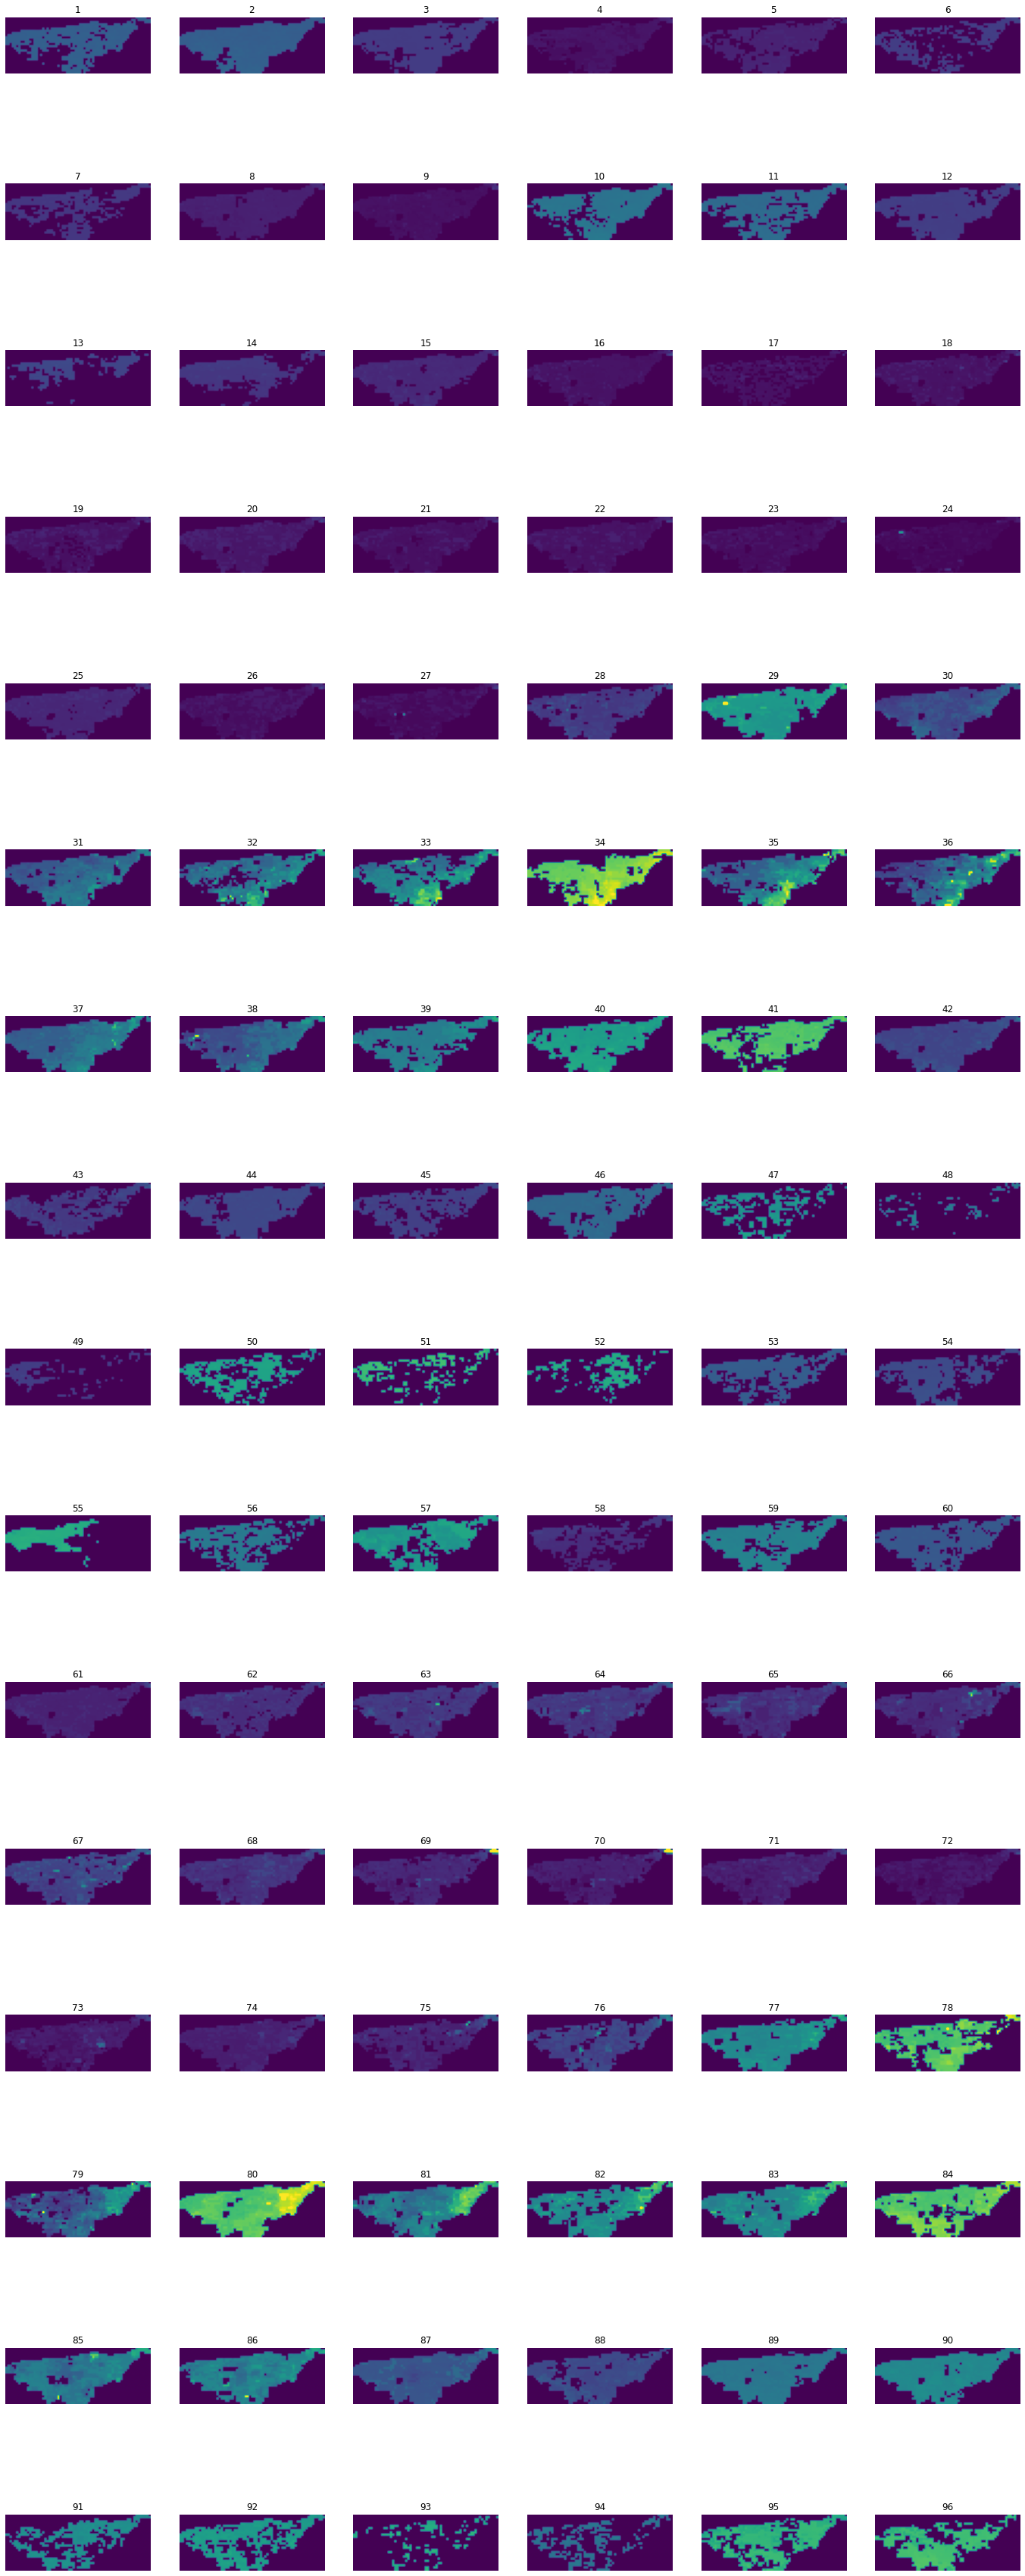

In [25]:
display_images(y)

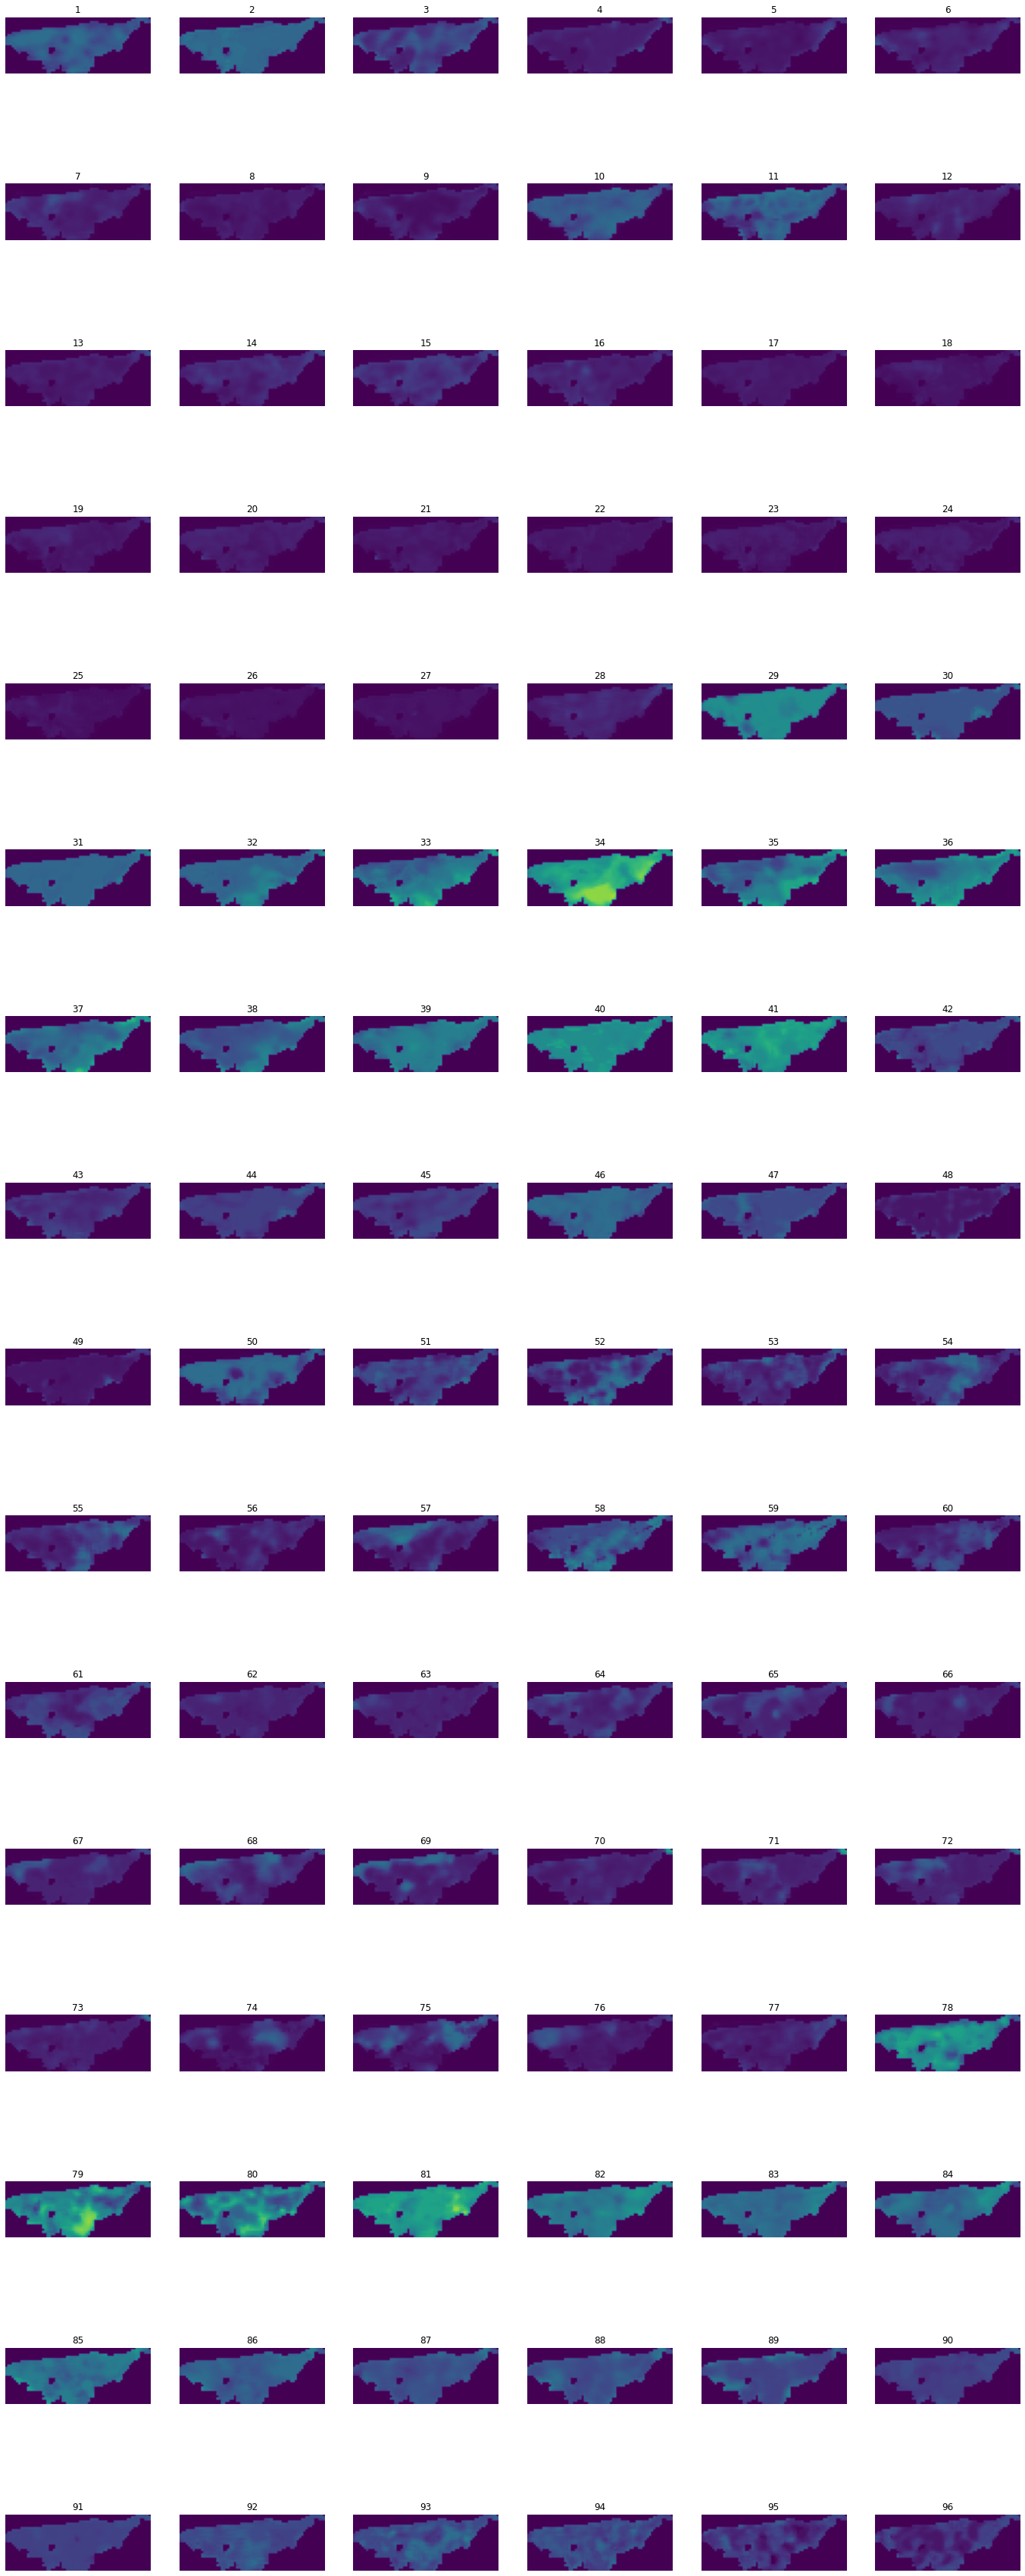

In [26]:
display_images(preds)

In [27]:
preds = preds * scale

In [28]:
cap = box[start:]

In [29]:
for n, pic in enumerate(preds):
    pic = np.reshape(pic, (pic.shape[0], pic.shape[1]))
    im = Image.fromarray(pic)
    im.save(f"{main_path}/maps/{data_path}/LE_map_{cap[n][23:30]}.tif")

In [30]:
print("\n-----------------------------------------------End of process-----------------------------------------------")


-----------------------------------------------End of process-----------------------------------------------
